# Feature Engineering 

In [1]:
import pandas as pd
import numpy as np
import math

from math import sqrt
import regex as re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter, FuncFormatter
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
from cycler import cycler

import seaborn as sns
sns.set()

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from textacy import preprocessing
import textacy
from nltk.corpus import stopwords
from nltk.stem import *

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from  sklearn.metrics  import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
# for one hot encoding with sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

# for the Q-Q plots
import scipy.stats as stats


# for one hot encoding with feature-engine
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error
# environment settings
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

## Imputing missing values
All missing values that are imputed in some way /mean, median, mode, other methods/ should be done separately for the training and the test set, in order to avoid data leakage.
Cardinality check, discretization and binning are taken into account

In [2]:
listings = pd.read_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/listings.pkl')

In [3]:
listings.drop('id',axis=1,inplace=True)

In [4]:
# plot the histograms to have a quick look at the variable distribution
# histogram and Q-Q plots

def diagnostic_plots(df, variable):
    
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()

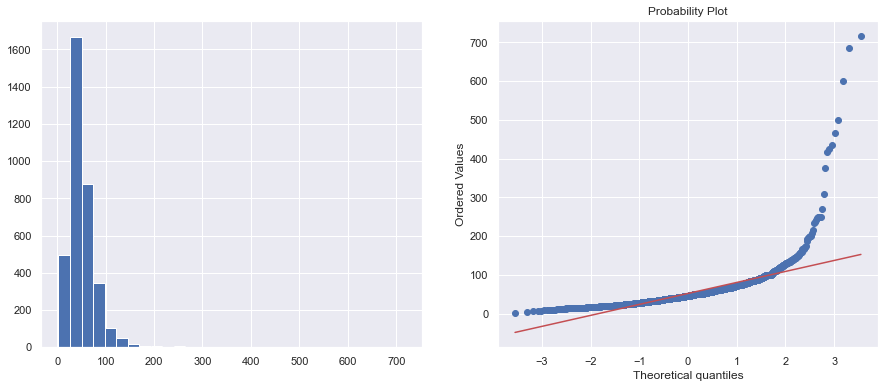

In [5]:
diagnostic_plots(listings,'price_per_person')

#### Transformation of target variable
The target variable price_per_person has a certain amount of outliers, which dostorts the analysis and the model. I am using a log transformation to normalize it, mainly to reduce the outliers' effect on the model. 

In [6]:
listings['price_per_person_log'] = np.log(listings['price_per_person'])

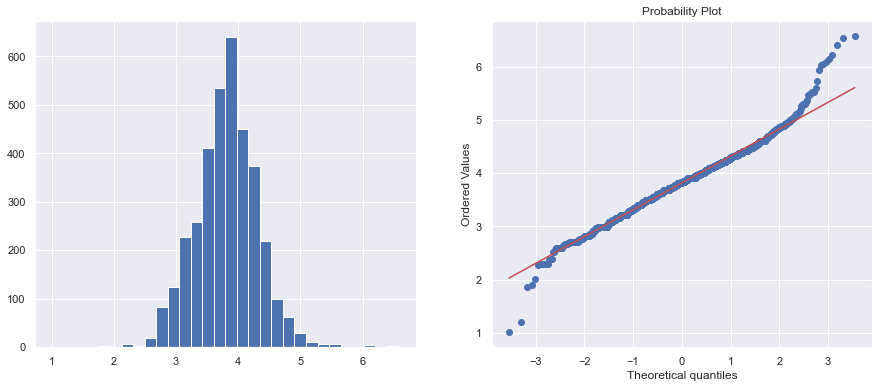

In [7]:
diagnostic_plots(listings,'price_per_person_log')

In [9]:
df = listings.drop(['price_per_person_log','price_per_person'],axis=1)
y = listings['price_per_person_log'].copy()

For the modelling part, I am using GridSearchCV, so I will leave just 10% of the data as final test set. The other will be used for the GridSearch Cross Validation /will use 5 k-fold cv/

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df, # just the features
                                                    y, # the target
                                                    test_size=0.1, # the percentage of obs in the test set
                                                    random_state=39) # for reproducibility

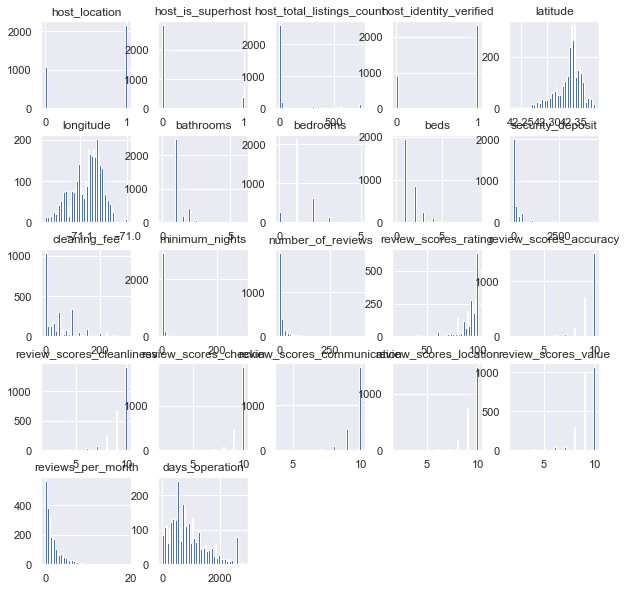

In [11]:
X_train.hist(bins=50, figsize=(10,10))
plt.show()

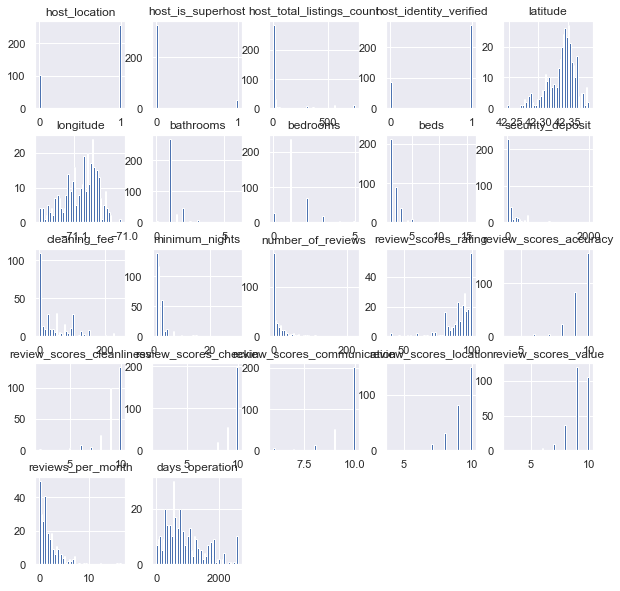

In [12]:
X_test.hist(bins=50, figsize=(10,10))
plt.show()

In [13]:
listings.isna().sum().sort_values(ascending = False)

review_scores_accuracy         823
review_scores_location         822
review_scores_value            821
review_scores_checkin          820
review_scores_cleanliness      818
review_scores_communication    818
review_scores_rating           813
reviews_per_month              756
host_response_time             471
host_acceptance_rate           471
host_response_rate             471
bathrooms                       14
bedrooms                        10
beds                             9
property_type                    3
city                             2
cancellation_policy              0
number_of_reviews                0
days_operation                   0
price_per_person                 0
host_location                    0
amenities                        0
minimum_nights                   0
cleaning_fee                     0
security_deposit                 0
bed_type                         0
room_type                        0
longitude                        0
latitude            

#### Imputing with missing category

In [14]:
#We will use missing value category for the review columns NAs, since the proportion of the missing data is huge - 20% of the total dataset
missing_value = ['reviews_per_month','review_scores_location',
                          'review_scores_value','review_scores_checkin','review_scores_cleanliness',
                          'review_scores_communication','review_scores_rating','review_scores_accuracy',
                'host_response_time']

for col in missing_value:
    X_train[col].fillna(-1,inplace=True)
    X_test[col].fillna(-1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


#### Host response rate and acceptance rate also have around 10% of missing data -> it is quite. So I will use a missing category to impute for the missing values, and discretization&binning

In [15]:
cols = ['host_response_rate','host_acceptance_rate']
for col in cols:
    X_train[col] = X_train[col].str.replace('%','')
    X_train[col] = pd.to_numeric(X_train[col])
    X_test[col] = X_test[col].str.replace('%','')
    X_test[col] = pd.to_numeric(X_test[col])

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/3168245722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].str.replace('%','')
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/3168245722.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = pd.to_numeric(X_train[col])
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/3168245722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [16]:
X_train['host_response_rate'].fillna(-1,inplace=True)
X_train['host_acceptance_rate'].fillna(-1,inplace=True)

X_test['host_response_rate'].fillna(-1,inplace=True)
X_test['host_acceptance_rate'].fillna(-1,inplace=True)

In [17]:
# bucket boundaries
buckets = [-1, 0, 20, 40, 50, 70, 90,100]
X_train['response_rate_buckets'] = pd.cut(X_train['host_response_rate'], bins=buckets, include_lowest=True)
X_test['response_rate_buckets'] = pd.cut(X_test['host_response_rate'], bins=buckets, include_lowest=True)

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/539011250.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['response_rate_buckets'] = pd.cut(X_train['host_response_rate'], bins=buckets, include_lowest=True)
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/539011250.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['response_rate_buckets'] = pd.cut(X_test['host_response_rate'], bins=buckets, include_lowest=True)


In [18]:
# bucket 2 boundaries
buckets2 = [-1, 0, 20, 40, 50, 70, 90,100]
X_train['accept_rate_buckets'] = pd.cut(X_train['host_acceptance_rate'], bins=buckets, include_lowest=True)
X_test['accept_rate_buckets'] = pd.cut(X_test['host_acceptance_rate'], bins=buckets, include_lowest=True)

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/2122951867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['accept_rate_buckets'] = pd.cut(X_train['host_acceptance_rate'], bins=buckets, include_lowest=True)
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/2122951867.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['accept_rate_buckets'] = pd.cut(X_test['host_acceptance_rate'], bins=buckets, include_lowest=True)


In [19]:
X_train['response_rate_buckets'].value_counts()

(90.0, 100.0]    2313
(-1.001, 0.0]     439
(70.0, 90.0]      368
(50.0, 70.0]       59
(20.0, 40.0]       20
(40.0, 50.0]       20
(0.0, 20.0]         7
Name: response_rate_buckets, dtype: int64

In [20]:
X_test['response_rate_buckets'].value_counts()

(90.0, 100.0]    255
(70.0, 90.0]      47
(-1.001, 0.0]     45
(50.0, 70.0]       8
(40.0, 50.0]       2
(0.0, 20.0]        1
(20.0, 40.0]       1
Name: response_rate_buckets, dtype: int64

In [21]:
X_train.drop(['host_response_rate','host_acceptance_rate'],axis=1,inplace=True)
X_test.drop(['host_response_rate','host_acceptance_rate'],axis=1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Imputing numerical & categorical variables with median and mode

In [22]:
# Imputing with median value - Based on the nature of the variables, as well as on their distribution, we are choosing what to impute with: variables with more close to normal distribution - mean; skewed variables - median
numeric_features_median = ['bathrooms','bedrooms','beds','days_operation']

for col in numeric_features_median:
    X_train[col].fillna(X_train[col].median(),inplace=True)
    X_test[col].fillna(X_test[col].median(),inplace=True)

In [23]:
#impute with mode for the categorical features
cat_features_mode = ['property_type','city']

for col in cat_features_mode:
    most = X_train[col].mode().values[0]
    X_train[col].fillna(most,inplace=True)
    most2 = X_test[col].mode().values[0]
    X_test[col].fillna(most2,inplace=True)

In [24]:
X_train.isna().sum()

host_location                  0
host_response_time             0
host_is_superhost              0
host_total_listings_count      0
host_identity_verified         0
neighbourhood_cleansed         0
city                           0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
bathrooms                      0
bedrooms                       0
beds                           0
bed_type                       0
amenities                      0
security_deposit               0
cleaning_fee                   0
minimum_nights                 0
number_of_reviews              0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
cancellation_policy            0
reviews_per_month              0
days_operation                 0
response_r

### Additional discretization of host_total_listings_count, days_operation and minimum_nights

In [25]:
X_train['host_total_listings_count'].max()

749

In [26]:
#The host needs to have at least 1 property
X_train.loc[X_train['host_total_listings_count']==0,'host_total_listings_count']=1
X_test.loc[X_test['host_total_listings_count']==0,'host_total_listings_count']=1

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [27]:
# buckets for host listings
buckets_host = [1,2,3,1000]
X_train['host_listings'] = pd.cut(X_train['host_total_listings_count'], bins=buckets_host, include_lowest=True)
X_test['host_listings'] = pd.cut(X_test['host_total_listings_count'], bins=buckets_host, include_lowest=True)

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/1216118954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['host_listings'] = pd.cut(X_train['host_total_listings_count'], bins=buckets_host, include_lowest=True)
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/1216118954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['host_listings'] = pd.cut(X_test['host_total_listings_count'], bins=buckets_host, include_lowest=True)


In [28]:
buckets_nights = [1,2,3,1000]
X_train['min_nights'] = pd.cut(X_train['minimum_nights'], bins=buckets_nights, include_lowest=True)
X_test['min_nights'] = pd.cut(X_test['minimum_nights'], bins=buckets_nights, include_lowest=True)

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/1755257232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['min_nights'] = pd.cut(X_train['minimum_nights'], bins=buckets_nights, include_lowest=True)
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/1755257232.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['min_nights'] = pd.cut(X_test['minimum_nights'], bins=buckets_nights, include_lowest=True)


In [29]:
X_train['days_operation'].max()

2857

In [30]:
buckets_days = [1,180,365,730,1095,5000]
X_train['days_oper'] = pd.cut(X_train['days_operation'], bins=buckets_days, include_lowest=True)
X_test['days_oper'] = pd.cut(X_test['days_operation'], bins=buckets_days, include_lowest=True)

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/1168726190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['days_oper'] = pd.cut(X_train['days_operation'], bins=buckets_days, include_lowest=True)
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/1168726190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['days_oper'] = pd.cut(X_test['days_operation'], bins=buckets_days, include_lowest=True)


In [31]:
X_train['days_oper'].value_counts()

(1095.0, 5000.0]    974
(365.0, 730.0]      903
(730.0, 1095.0]     722
(180.0, 365.0]      315
(0.999, 180.0]      312
Name: days_oper, dtype: int64

In [32]:
X_train.shape

(3226, 35)

In [33]:
X_test.shape

(359, 35)

#### Cardinality check

In [34]:
X_train['host_response_time'].value_counts()

within an hour        1249
within a few hours    1090
-1                     427
within a day           421
a few days or more      39
Name: host_response_time, dtype: int64

In [35]:
X_test['host_response_time'].value_counts()

within an hour        135
within a few hours    128
within a day           48
-1                     44
a few days or more      4
Name: host_response_time, dtype: int64

In [36]:
X_train['city'].value_counts()

Boston                       3051
Roxbury Crossing               21
Somerville                     15
Jamaica Plain                  15
Dorchester                     14
Cambridge                      14
Brighton                       13
Brookline                      13
Allston                        12
Charlestown                    12
Roslindale                      6
West Roxbury                    5
ROXBURY CROSSING                4
Mattapan                        3
East Boston                     3
Boston, Massachusetts, US       2
Hyde Park                       2
ALLSTON                         2
South Boston                    2
Jamaica Plain                   2
boston                          1
Boston                          1
Newton                          1
波士顿                             1
Roslindale, Boston              1
Boston (Jamaica Plain)          1
Mission Hill, Boston            1
Jamaica Plain, Boston           1
Jamaica Plain (Boston)          1
Brighton      

In [37]:
#THe prevailing value was Boston, so we marked the city with 1 for Boston, and 0 for the rest
X_train['city']=np.where(X_train['city']=='Boston',1,0)
X_test['city']=np.where(X_test['city']=='Boston',1,0)

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/1657766666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['city']=np.where(X_train['city']=='Boston',1,0)
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/1657766666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['city']=np.where(X_test['city']=='Boston',1,0)


#### Categorical handling of аmenities

In [38]:
def text_cleaner_open_amenities(serie, words= []):
    '''
    input: pandas series, stop words
    ouput: removes special char, stop words, symbols.'''
    serie = serie.astype(str).str.lower()
    #st = PorterStemmer()
    stop= stopwords.words('english') + words
    stop = [x for x in stop]
    
    serie=serie.str.replace('"','')
    serie=serie.str.replace('{','')
    serie=serie.str.replace('}','')
    serie= serie.apply(lambda x: " ".join([word for word in x.split() 
                                           if word not in stop])) 
    return serie

In [39]:
X_train['amenities'] = text_cleaner_open_amenities(X_train['amenities'])
X_test['amenities'] = text_cleaner_open_amenities(X_test['amenities'])

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/4007061188.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  serie=serie.str.replace('{','')
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/4007061188.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  serie=serie.str.replace('}','')
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_3475/4267831456.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [40]:
vectorizer_am = CountVectorizer(tokenizer=lambda x: x.split(','))
vectorizer_am.fit(X_train['amenities'])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(tokenizer=<function <lambda> at 0x7fc080fa9dc0>)

In [41]:
vectorizer_am.get_feature_names()

['',
 '24-hour check-in',
 'air conditioning',
 'breakfast',
 'buzzer/wireless intercom',
 'cable tv',
 'carbon monoxide detector',
 'cat(s)',
 'dog(s)',
 'doorman',
 'dryer',
 'elevator building',
 'essentials',
 'family/kid friendly',
 'fire extinguisher',
 'first aid kit',
 'free parking premises',
 'free parking street',
 'gym',
 'hair dryer',
 'hangers',
 'heating',
 'hot tub',
 'indoor fireplace',
 'internet',
 'iron',
 'kitchen',
 'laptop friendly workspace',
 'lock bedroom door',
 'other pet(s)',
 'paid parking premises',
 'pets allowed',
 'pets live property',
 'pool',
 'safety card',
 'shampoo',
 'smoke detector',
 'smoking allowed',
 'suitable events',
 'translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50',
 'tv',
 'washer',
 'washer / dryer',
 'wheelchair accessible',
 'wireless internet']

In [42]:
dt = vectorizer_am.transform(X_train['amenities'])

In [43]:
dt.shape

(3226, 46)

In [44]:
X_train = X_train.join(pd.DataFrame(dt.toarray(), columns=vectorizer_am.get_feature_names(), index= X_train.index))

In [45]:
X_train.shape

(3226, 81)

In [46]:
dt1 = vectorizer_am.transform(X_test['amenities'])

In [47]:
X_test = X_test.join(pd.DataFrame(dt1.toarray(), columns=vectorizer_am.get_feature_names(), index= X_test.index))

In [48]:
X_test.shape

(359, 81)

In [49]:
#combine some of the features
X_train.loc[X_train['wireless internet']==1,'internet']=1
X_test.loc[X_test['wireless internet']==1,'internet']=1

In [50]:
X_train.loc[X_train['tv']==1,'cable tv']=1
X_test.loc[X_test['tv']==1,'cable tv']=1

In [51]:
X_train.loc[X_train['washer / dryer']==1,'washer']=1
X_train.loc[X_train['washer / dryer']==1,'dryer']=1

X_test.loc[X_test['washer / dryer']==1,'washer']=1
X_test.loc[X_test['washer / dryer']==1,'dryer']=1

In [52]:
X_train.drop(['','translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50','wireless internet','tv','washer / dryer'],axis=1,inplace=True)

In [53]:
X_test.drop(['','translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50','wireless internet','tv','washer / dryer'],axis=1,inplace=True)

In [54]:
X_train.shape

(3226, 75)

In [55]:
X_test.shape

(359, 75)

In [56]:
X_train.drop(columns={'host_total_listings_count','minimum_nights','days_operation'},axis=1,inplace=True)
X_test.drop(columns={'host_total_listings_count','minimum_nights','days_operation'},axis=1,inplace=True)

### Outliers
The outliers should be removed from the training set. We are treating the test set as not seen before, so outliers are not to be evaluated and removed from there. 

In [57]:
def find_skewed_boundaries(df, variable, distance):

    # Function to find the outliers 
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [58]:
train = X_train.join(y_train)

In [59]:
RM_upper_limit, RM_lower_limit = find_skewed_boundaries(train, 'price_per_person_log', 1.5)
RM_upper_limit, RM_lower_limit

(5.085447612417449, 2.5513647972838687)

In [60]:
train['outliers_price'] = np.where(train['price_per_person_log'] > RM_upper_limit, True,
                       np.where(train['price_per_person_log'] < RM_lower_limit, True, False))

In [61]:
train['outliers_price'].value_counts()

False    3182
True       44
Name: outliers_price, dtype: int64

In [62]:
44/3226

0.013639181649101054

The outliers by price are 1% of the total data, so we can just remove them.

In [63]:
train = train[train['outliers_price']==False]

In [64]:
train.head()

,host_location,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_cleansed,city,latitude,longitude,property_type,room_type,bathrooms,bedrooms,beds,bed_type,amenities,security_deposit,cleaning_fee,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,response_rate_buckets,accept_rate_buckets,host_listings,min_nights,days_oper,24-hour check-in,air conditioning,breakfast,buzzer/wireless intercom,cable tv,carbon monoxide detector,cat(s),dog(s),doorman,dryer,elevator building,essentials,family/kid friendly,fire extinguisher,first aid kit,free parking premises,free parking street,gym,hair dryer,hangers,heating,hot tub,indoor fireplace,internet,iron,kitchen,laptop friendly workspace,lock bedroom door,other pet(s),paid parking premises,pets allowed,pets live property,pool,safety card,shampoo,smoke detector,smoking allowed,suitable events,washer,wheelchair accessible,price_per_person_log,outliers_price
2671,0,-1,0,0,West Roxbury,1,42.263443,-71.148642,House,Private room,2.0,1.0,2.0,Real Bed,"tv,wireless internet,kitchen,free parking prem...",0.0,0.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,flexible,-1.00,"(-1.001, 0.0]","(-1.001, 0.0]","(0.999, 2.0]","(0.999, 2.0]","(365.0, 730.0]",0,0,0,1,1,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,3.976499,False
350,0,within an hour,0,1,Jamaica Plain,1,42.321365,-71.113231,Apartment,Private room,1.0,1.0,1.0,Real Bed,"wireless internet,kitchen,pets allowed,heating...",0.0,0.0,3,100.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,0.78,"(90.0, 100.0]","(90.0, 100.0]","(0.999, 2.0]","(0.999, 2.0]","(730.0, 1095.0]",0,0,0,0,0,1,0,0,0,1,0,1,1,1,1,0,0,0,1,1,1,0,0,1,1,1,1,1,0,0,1,0,0,1,0,1,0,0,1,0,3.075929,False
2926,1,within a few hours,0,1,Dorchester,1,42.318034,-71.054511,Apartment,Private room,1.0,1.0,1.0,Real Bed,"wireless internet,kitchen,heating,smoke detect...",100.0,49.0,5,88.0,8.0,8.0,10.0,10.0,9.0,8.0,strict,0.22,"(70.0, 90.0]","(90.0, 100.0]","(3.0, 1000.0]","(2.0, 3.0]","(730.0, 1095.0]",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.198673,False
3257,1,within an hour,0,1,South Boston,1,42.330628,-71.053148,Condominium,Private room,1.0,1.0,1.0,Real Bed,"tv,internet,wireless internet,air conditioning...",150.0,30.0,16,94.0,10.0,10.0,10.0,9.0,9.0,10.0,strict,2.79,"(90.0, 100.0]","(90.0, 100.0]","(3.0, 1000.0]","(0.999, 2.0]","(1095.0, 5000.0]",1,1,0,1,1,1,0,0,0,1,0,1,1,1,0,0,1,0,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,1,0,4.083115,False
1376,1,within a few hours,0,1,Back Bay,1,42.349262,-71.084401,Apartment,Private room,1.0,1.0,1.0,Real Bed,"tv,cable tv,internet,wireless internet,air con...",0.0,50.0,5,96.0,10.0,10.0,10.0,10.0,10.0,10.0,strict,5.00,"(90.0, 100.0]","(90.0, 100.0]","(0.999, 2.0]","(0.999, 2.0]","(730.0, 1095.0]",0,1,0,1,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,1,1,0,1,1,1,1,1,1,0,0,0,1,0,0,1,1,0,0,1,0,4.551242,False


In [65]:
train.drop(['amenities','outliers_price'],axis=1,inplace=True)

In [66]:
X_test.drop(['amenities'],axis=1,inplace=True)

In [67]:
X_train = train.drop('price_per_person_log',axis=1)
y_train = train['price_per_person_log'].copy()

In [68]:
X_train.shape

(3182, 71)

In [69]:
y_train.shape

(3182,)

In [70]:
X_train.head()

,host_location,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_cleansed,city,latitude,longitude,property_type,room_type,bathrooms,bedrooms,beds,bed_type,security_deposit,cleaning_fee,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,response_rate_buckets,accept_rate_buckets,host_listings,min_nights,days_oper,24-hour check-in,air conditioning,breakfast,buzzer/wireless intercom,cable tv,carbon monoxide detector,cat(s),dog(s),doorman,dryer,elevator building,essentials,family/kid friendly,fire extinguisher,first aid kit,free parking premises,free parking street,gym,hair dryer,hangers,heating,hot tub,indoor fireplace,internet,iron,kitchen,laptop friendly workspace,lock bedroom door,other pet(s),paid parking premises,pets allowed,pets live property,pool,safety card,shampoo,smoke detector,smoking allowed,suitable events,washer,wheelchair accessible
2671,0,-1,0,0,West Roxbury,1,42.263443,-71.148642,House,Private room,2.0,1.0,2.0,Real Bed,0.0,0.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,flexible,-1.00,"(-1.001, 0.0]","(-1.001, 0.0]","(0.999, 2.0]","(0.999, 2.0]","(365.0, 730.0]",0,0,0,1,1,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0
350,0,within an hour,0,1,Jamaica Plain,1,42.321365,-71.113231,Apartment,Private room,1.0,1.0,1.0,Real Bed,0.0,0.0,3,100.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,0.78,"(90.0, 100.0]","(90.0, 100.0]","(0.999, 2.0]","(0.999, 2.0]","(730.0, 1095.0]",0,0,0,0,0,1,0,0,0,1,0,1,1,1,1,0,0,0,1,1,1,0,0,1,1,1,1,1,0,0,1,0,0,1,0,1,0,0,1,0
2926,1,within a few hours,0,1,Dorchester,1,42.318034,-71.054511,Apartment,Private room,1.0,1.0,1.0,Real Bed,100.0,49.0,5,88.0,8.0,8.0,10.0,10.0,9.0,8.0,strict,0.22,"(70.0, 90.0]","(90.0, 100.0]","(3.0, 1000.0]","(2.0, 3.0]","(730.0, 1095.0]",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3257,1,within an hour,0,1,South Boston,1,42.330628,-71.053148,Condominium,Private room,1.0,1.0,1.0,Real Bed,150.0,30.0,16,94.0,10.0,10.0,10.0,9.0,9.0,10.0,strict,2.79,"(90.0, 100.0]","(90.0, 100.0]","(3.0, 1000.0]","(0.999, 2.0]","(1095.0, 5000.0]",1,1,0,1,1,1,0,0,0,1,0,1,1,1,0,0,1,0,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,1,0
1376,1,within a few hours,0,1,Back Bay,1,42.349262,-71.084401,Apartment,Private room,1.0,1.0,1.0,Real Bed,0.0,50.0,5,96.0,10.0,10.0,10.0,10.0,10.0,10.0,strict,5.00,"(90.0, 100.0]","(90.0, 100.0]","(0.999, 2.0]","(0.999, 2.0]","(730.0, 1095.0]",0,1,0,1,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,1,1,0,1,1,1,1,1,1,0,0,0,1,0,0,1,1,0,0,1,0


### One-hot encoding of categorical variables

I use the one hot encoder from the feature engine, because it is clear, can point the variables, as well as returns back a datarame. 
__For Linear regression model - encode into K-1 variables<br>
For tree models - encode into K variables, since with the ensemble methods we are not using all features__
I am using the One-hot encoder from the feature engine, since it directly returns a dataframe w/o the original variable, with the respective names etc.

In [71]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3182 entries, 2671 to 3465
Data columns (total 71 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   host_location                3182 non-null   int64   
 1   host_response_time           3182 non-null   object  
 2   host_is_superhost            3182 non-null   int64   
 3   host_identity_verified       3182 non-null   int64   
 4   neighbourhood_cleansed       3182 non-null   object  
 5   city                         3182 non-null   int64   
 6   latitude                     3182 non-null   float64 
 7   longitude                    3182 non-null   float64 
 8   property_type                3182 non-null   object  
 9   room_type                    3182 non-null   object  
 10  bathrooms                    3182 non-null   float64 
 11  bedrooms                     3182 non-null   float64 
 12  beds                         3182 non-null   float64 
 13  

In [72]:
X_train.describe(include='object').transpose()

,count,unique,top,freq
host_response_time,3182,5,within an hour,1237
neighbourhood_cleansed,3182,25,Jamaica Plain,299
property_type,3182,11,Apartment,2322
room_type,3182,3,Entire home/apt,1900
bed_type,3182,5,Real Bed,3065
cancellation_policy,3182,4,strict,1406


In [73]:
X_train.describe(include='category').transpose()

,count,unique,top,freq
response_rate_buckets,3182,7,"(90.0, 100.0]",2289
accept_rate_buckets,3182,7,"(90.0, 100.0]",1676
host_listings,3182,3,"(0.999, 2.0]",1871
min_nights,3182,3,"(0.999, 2.0]",2138
days_oper,3182,5,"(1095.0, 5000.0]",966


In [74]:
ohe_enc = fe_OneHotEncoder(
    top_categories=None,
    variables=['host_response_time','neighbourhood_cleansed','property_type','room_type','bed_type','cancellation_policy','response_rate_buckets','accept_rate_buckets','host_listings','min_nights','days_oper'],  # we can select which variables to encode
    drop_last=False)  # to return k-1, false to return k

ohe_enc.fit(X_train)

OneHotEncoder(variables=['host_response_time', 'neighbourhood_cleansed',
                         'property_type', 'room_type', 'bed_type',
                         'cancellation_policy', 'response_rate_buckets',
                         'accept_rate_buckets', 'host_listings', 'min_nights',
                         'days_oper'])

In [75]:
X_train_tr = ohe_enc.transform(X_train)

X_train_tr.head()

,host_location,host_is_superhost,host_identity_verified,city,latitude,longitude,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,24-hour check-in,air conditioning,breakfast,buzzer/wireless intercom,cable tv,carbon monoxide detector,cat(s),dog(s),doorman,dryer,elevator building,essentials,family/kid friendly,fire extinguisher,first aid kit,free parking premises,free parking street,gym,hair dryer,hangers,heating,hot tub,indoor fireplace,internet,iron,kitchen,laptop friendly workspace,lock bedroom door,other pet(s),paid parking premises,pets allowed,pets live property,pool,safety card,shampoo,smoke detector,smoking allowed,suitable events,washer,wheelchair accessible,host_response_time_-1,host_response_time_within an hour,host_response_time_within a few hours,host_response_time_within a day,host_response_time_a few days or more,neighbourhood_cleansed_West Roxbury,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_South End,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_North End,neighbourhood_cleansed_West End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Leather District,property_type_House,property_type_Apartment,property_type_Condominium,property_type_Villa,property_type_Townhouse,property_type_Bed & Breakfast,property_type_Loft,property_type_Boat,property_type_Other,property_type_Entire Floor,property_type_Guesthouse,room_type_Private room,room_type_Entire home/apt,room_type_Shared room,bed_type_Real Bed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Airbed,cancellation_policy_flexible,cancellation_policy_strict,cancellation_policy_moderate,cancellation_policy_super_strict_30,"response_rate_buckets_(-1.001, 0.0]","response_rate_buckets_(90.0, 100.0]","response_rate_buckets_(70.0, 90.0]","response_rate_buckets_(50.0, 70.0]","response_rate_buckets_(40.0, 50.0]","response_rate_buckets_(20.0, 40.0]","response_rate_buckets_(0.0, 20.0]","accept_rate_buckets_(-1.001, 0.0]","accept_rate_buckets_(90.0, 100.0]","accept_rate_buckets_(50.0, 70.0]","accept_rate_buckets_(70.0, 90.0]","accept_rate_buckets_(40.0, 50.0]","accept_rate_buckets_(20.0, 40.0]","accept_rate_buckets_(0.0, 20.0]","host_listings_(0.999, 2.0]","host_listings_(3.0, 1000.0]","host_listings_(2.0, 3.0]","min_nights_(0.999, 2.0]","min_nights_(2.0, 3.0]","min_nights_(3.0, 1000.0]","days_oper_(365.0, 730.0]","days_oper_(730.0, 1095.0]","days_oper_(1095.0, 5000.0]","days_oper_(180.0, 365.0]","days_oper_(0.999, 180.0]"
2671,0,0,0,1,42.263443,-71.148642,2.0,1.0,2.0,0.0,0.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,0,0,0,1,1,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
350,0,0,1,1,42.321365,-71.113231,1.0,1.0,1.0,0.0,0.0,3,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0.78,0,0,0,0,0,1,0,0,0,1,0,1,1,1,1,0,0,0,1,1,1,0,0,1,1,1,1,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
2926,1,0,1,1,42.318034,-71.054511,1.0,1.0,1.0,100.0,49.0,5,88.0,8.0,8.0,10.0,10.0,9.0

In [76]:
X_train_tr.shape

(3182, 138)

In [77]:
X_test_tr = ohe_enc.transform(X_test)

X_test_tr.head()

,host_location,host_is_superhost,host_identity_verified,city,latitude,longitude,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,24-hour check-in,air conditioning,breakfast,buzzer/wireless intercom,cable tv,carbon monoxide detector,cat(s),dog(s),doorman,dryer,elevator building,essentials,family/kid friendly,fire extinguisher,first aid kit,free parking premises,free parking street,gym,hair dryer,hangers,heating,hot tub,indoor fireplace,internet,iron,kitchen,laptop friendly workspace,lock bedroom door,other pet(s),paid parking premises,pets allowed,pets live property,pool,safety card,shampoo,smoke detector,smoking allowed,suitable events,washer,wheelchair accessible,host_response_time_-1,host_response_time_within an hour,host_response_time_within a few hours,host_response_time_within a day,host_response_time_a few days or more,neighbourhood_cleansed_West Roxbury,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_South End,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_North End,neighbourhood_cleansed_West End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Leather District,property_type_House,property_type_Apartment,property_type_Condominium,property_type_Villa,property_type_Townhouse,property_type_Bed & Breakfast,property_type_Loft,property_type_Boat,property_type_Other,property_type_Entire Floor,property_type_Guesthouse,room_type_Private room,room_type_Entire home/apt,room_type_Shared room,bed_type_Real Bed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Airbed,cancellation_policy_flexible,cancellation_policy_strict,cancellation_policy_moderate,cancellation_policy_super_strict_30,"response_rate_buckets_(-1.001, 0.0]","response_rate_buckets_(90.0, 100.0]","response_rate_buckets_(70.0, 90.0]","response_rate_buckets_(50.0, 70.0]","response_rate_buckets_(40.0, 50.0]","response_rate_buckets_(20.0, 40.0]","response_rate_buckets_(0.0, 20.0]","accept_rate_buckets_(-1.001, 0.0]","accept_rate_buckets_(90.0, 100.0]","accept_rate_buckets_(50.0, 70.0]","accept_rate_buckets_(70.0, 90.0]","accept_rate_buckets_(40.0, 50.0]","accept_rate_buckets_(20.0, 40.0]","accept_rate_buckets_(0.0, 20.0]","host_listings_(0.999, 2.0]","host_listings_(3.0, 1000.0]","host_listings_(2.0, 3.0]","min_nights_(0.999, 2.0]","min_nights_(2.0, 3.0]","min_nights_(3.0, 1000.0]","days_oper_(365.0, 730.0]","days_oper_(730.0, 1095.0]","days_oper_(1095.0, 5000.0]","days_oper_(180.0, 365.0]","days_oper_(0.999, 180.0]"
2294,1,0,1,1,42.346550,-71.092910,1.0,1.0,16.0,200.0,0.0,8,93.0,10.0,9.0,10.0,10.0,10.0,9.0,1.69,0,1,0,1,0,1,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
1966,1,1,1,1,42.357034,-71.070562,2.5,4.0,5.0,1500.0,150.0,11,96.0,10.0,9.0,10.0,10.0,10.0,9.0,0.85,1,1,0,0,1,1,0,0,0,1,0,1,1,1,0,0,0,0,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
2995,1,0,1,0,42.311442,-71.057637,1.0,1.0,1.0,100.0,50.0,3,73.0,6.0,5.0,9.0,7.0,7

In [78]:
X_test_tr.shape

(359, 138)

In [79]:
X_train_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3182 entries, 2671 to 3465
Columns: 138 entries, host_location to days_oper_(0.999, 180.0]
dtypes: float64(15), int64(123)
memory usage: 3.4 MB


In [80]:
X_test_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359 entries, 2294 to 1776
Columns: 138 entries, host_location to days_oper_(0.999, 180.0]
dtypes: float64(15), int64(123)
memory usage: 398.0 KB


In [81]:
y_train.shape

(3182,)

In [82]:
y_test.shape

(359,)

In [83]:
X_train_tr.to_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/X_train.pkl')
y_train.to_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/y_train.pkl')
X_test_tr.to_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/X_test.pkl')
y_test.to_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/y_test.pkl')